In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix

import os
import sys
classes_dir = 'C:\Documents\Thesis_ssd\MasterThesis-2.0'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.BaselineHelperFunctions import BaselineHelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes import Tf_shutup
Tf_shutup.Tf_shutup()

from livelossplot import PlotLossesKeras

import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = BaselineHelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

base_dir = 'C:\Documents\Thesis_ssd\MasterThesis-2.0'
os.chdir(base_dir)

In [2]:
num_classes = 3
loadData = LoadData(num_classes = num_classes, isBalanced = True)
shuffle = True
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
data_gen = DataGenerator()

In [3]:
"""
{'model_nr': 5, 'index': 10}
{'batch_size': 32, 'epochs': 35, 'learning_rate': 1e-05, 'optimizer': 'rmsprop'}
{'activation': 'relu', 'dropout_rate': 0.4, 'filters': 21, 'kernel_size': 7, 'l1_r': 0.001, 'l2_r': 0.2, 
'output_layer_activation': 'sigmoid', 'padding': 'same', 'start_neurons': 16}

{'model_nr': 4, 'index': 10}
{'batch_size': 8, 'epochs': 30, 'learning_rate': 0.0001, 'optimizer': 'adam'}
{'activation': 'relu', 'dropout_rate': 0.3, 'filters': 17, 'kernel_size': 3, 'l1_r': 0.01, 'l2_r': 0.1, 
'output_layer_activation': 'softmax', 'padding': 'same', 'start_neurons': 128}

Crashing model:
Test_mode: False, use_scaler: True, use_minmax: False, use_noise_augmentor: True, detrend: False
{'model_nr': 4, 'index': 21}
{'batch_size': 16, 'epochs': 35, 'learning_rate': 0.001, 'optimizer': 'sgd'}
{'activation': 'relu', 'dropout_rate': 0.01, 'filters': 15, 'kernel_size': 13, 'l1_r': 0.0001, 
'l2_r': 0.2, 'output_layer_activation': 'sigmoid', 'padding': 'same', 'start_neurons': 64}

{'model_nr': 7, 'index': 38}
Test_mode: False, use_scaler: True, use_minmax: False, use_noise_augmentor: True detrend: False. 
{'batch_size': 64, 'epochs': 40, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
{'activation': 'tanh', 'dropout_rate': 0, 'filters': 13, 'kernel_size': 5, 'l1_r': 0.0001,
'l2_r': 0.01, 'output_layer_activation': 'softmax', 'padding': 'same', 'start_neurons': 32}
{'test_loss': 1.4299607276916504, 'test_accuracy': 0.7728365659713745, 
'test_precision': 0.7728365659713745, 'test_recall': 0.7728365659713745}
{'train_loss': 0.9629267454147339, 'train_accuracy': 0.8897058963775635, 
'train_precision': 0.8897058963775635, 'train_recall': 0.8897058963775635}

"""
############ Model picker #############
model_nr = 8

########### Hyperparameters ###########
batch_size = 64
epochs = 80
learning_rate = 0.001
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0, clipvalue=0.5)
opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
activation = 'tanh'
output_layer_activation = 'softmax'
dropout_rate = 0
filters = 13
kernel_size = 5
l1_r = 0.0001
l2_r = 0.01
padding = 'same'
start_neurons = 32

########### Preprocessing ###########
test = False
use_noise_augmentor = True
detrend = False
use_scaler = True
use_highpass = False
highpass_freq = 0.2

use_tensorboard = True
use_livelossplot = False
use_custom = False

In [4]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))
        
if use_tensorboard:
    import datetime
    clear_tensorboard_dir()
    %load_ext tensorboard
    %tensorboard --logdir tensorboard_dir/fit
    log_dir = f"{base_dir}/tensorboard_dir/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [tensorboard_callback]

if use_custom:
    custom_callback = CustomCallback(data_gen)
    callbacks = custom_callback
elif use_livelossplot:
    callbacks = PlotLossesKeras()

['20201019-150002']


Reusing TensorBoard on port 6006 (pid 13444), started 3:42:05 ago. (Use '!kill 13444' to kill it.)

In [5]:
num_ds, channels, timesteps = data_gen.get_trace_shape_no_cast(train_ds)
input_shape = (batch_size, channels, timesteps)

build_model_args = {'model_nr' : model_nr,
                    'input_shape' : input_shape,
                    'num_classes' : num_classes,
                    'dropout_rate' : dropout_rate,
                    'activation' : activation,
                    'output_layer_activation' : output_layer_activation,
                    'l2_r' : l2_r,
                    'l1_r' : l1_r,
                    'full_regularizer' : True,
                    'start_neurons' : start_neurons,
                    'filters' : filters,
                    'kernel_size' : kernel_size,
                    'padding' : 'same'}
model = Models(**build_model_args).model

model_args = {'loss' : "binary_crossentropy",
              'optimizer' : opt,
              'metrics' : ["accuracy","MSE",
                           tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
                           tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)]}
model.compile(**model_args)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (64, 3, 32)               772352    
_________________________________________________________________
dropout (Dropout)            (64, 3, 32)               0         
_________________________________________________________________
batch_normalization (BatchNo (64, 3, 32)               128       
_________________________________________________________________
lstm_1 (LSTM)                (64, 3, 16)               3136      
_________________________________________________________________
dropout_1 (Dropout)          (64, 3, 16)               0         
_________________________________________________________________
batch_normalization_1 (Batch (64, 3, 16)               64        
_________________________________________________________________
dense (Dense)                (64, 3, 8)                1

In [6]:
scaler = None
if use_scaler:
    scaler = StandardScalerFitter(train_ds).fit_scaler(test = test, detrend = detrend)
aug = None
if use_noise_augmentor:
    aug = NoiseAugmentor(train_ds, use_scaler, scaler)
    
    

gen_args = {
    'batch_size' : batch_size,
    'test' : test,
    'detrend' : detrend,
    'use_scaler' : use_scaler,
    'scaler' : scaler,
    'use_noise_augmentor' : use_noise_augmentor,
    'augmentor' : aug,
    'num_classes' : num_classes,
    'use_highpass' : use_highpass,
    'highpass_freq' : highpass_freq
}


train_gen = data_gen.data_generator(train_ds, **gen_args)
val_gen = data_gen.data_generator(val_ds, **gen_args)
test_gen = data_gen.data_generator(test_ds, **gen_args)



args = {'steps_per_epoch' : helper.get_steps_per_epoch(train_ds, batch_size, test),
        'epochs' : epochs,
        'validation_data' : val_gen,
        'validation_steps' : helper.get_steps_per_epoch(val_ds, batch_size, test),
        'verbose' : 1,
        'use_multiprocessing' : False, 
        'workers' : 1,
        'callbacks' : [callbacks]
}

model_fit = model.fit(train_gen, **args)

Epoch 1/80
  1/256 [..............................] - ETA: 0s - loss: 5.5937 - accuracy: 0.3750 - MSE: 0.2773 - precision: 0.3261 - recall: 0.2344WARNING:tensorflow:From C:\Users\tss_9\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
257/256 [==============================] - 47s 182ms/step - loss: 2.3036 - accuracy: 0.4260 - MSE: 0.2206 - precision: 0.4897 - recall: 0.1975 - val_loss: 1.5468 - val_accuracy: 0.3837 - val_MSE: 0.2194 - val_precision: 0.7500 - val_recall: 0.0021
Epoch 2/80
257/256 [==============================] - 44s 169ms/step - loss: 1.3132 - accuracy: 0.5268 - MSE: 0.1911 - precision: 0.6557 - recall: 0.3029 - val_loss: 1.2453 - val_accuracy: 0.4934 - val_MSE: 0.2002 - val_precision: 0.6764 - val_recall: 0.1771
Epoch 3/80
257/256 [==============================] - 43s 169ms/s

Epoch 30/80
257/256 [==============================] - 46s 179ms/step - loss: 0.8591 - accuracy: 0.7759 - MSE: 0.1039 - precision: 0.8137 - recall: 0.7294 - val_loss: 1.1213 - val_accuracy: 0.5955 - val_MSE: 0.1816 - val_precision: 0.6217 - val_recall: 0.5569
Epoch 31/80
257/256 [==============================] - 59s 229ms/step - loss: 0.8455 - accuracy: 0.7779 - MSE: 0.1041 - precision: 0.8133 - recall: 0.7279 - val_loss: 1.1478 - val_accuracy: 0.6108 - val_MSE: 0.1801 - val_precision: 0.6388 - val_recall: 0.5729
Epoch 32/80
257/256 [==============================] - 67s 261ms/step - loss: 0.8373 - accuracy: 0.7795 - MSE: 0.1018 - precision: 0.8171 - recall: 0.7335 - val_loss: 1.1190 - val_accuracy: 0.6132 - val_MSE: 0.1799 - val_precision: 0.6361 - val_recall: 0.5736- accuracy: 0.7817 - MSE: 0.101 - ETA: 10s - loss: 0.8322 - accuracy: 0.7819 - MSE: 0.1010 - precision: 0.81 - ETA: 6s - loss: 0.8375 - accuracy: 0.7792 - MSE: 0.1017 - precision: 0.8174 - r - ETA: 4s - loss: 0.8374 - acc

Epoch 59/80
257/256 [==============================] - 46s 177ms/step - loss: 0.7755 - accuracy: 0.8058 - MSE: 0.0913 - precision: 0.8336 - recall: 0.7740 - val_loss: 1.0933 - val_accuracy: 0.6406 - val_MSE: 0.1715 - val_precision: 0.6556 - val_recall: 0.6122
Epoch 60/80
257/256 [==============================] - 46s 178ms/step - loss: 0.7746 - accuracy: 0.8045 - MSE: 0.0907 - precision: 0.8323 - recall: 0.7744 - val_loss: 1.0946 - val_accuracy: 0.6271 - val_MSE: 0.1778 - val_precision: 0.6423 - val_recall: 0.6049
Epoch 61/80
257/256 [==============================] - 48s 187ms/step - loss: 0.7674 - accuracy: 0.8077 - MSE: 0.0915 - precision: 0.8350 - recall: 0.7771 - val_loss: 1.1249 - val_accuracy: 0.6226 - val_MSE: 0.1887 - val_precision: 0.6373 - val_recall: 0.6076cy: 0.8057 - MSE: 0.0922 
Epoch 62/80
257/256 [==============================] - 48s 187ms/step - loss: 0.7777 - accuracy: 0.8067 - MSE: 0.0910 - precision: 0.8312 - recall: 0.7735 - val_loss: 1.0999 - val_accuracy: 0.631

In [7]:
full_logs = custom_callback.full_training_logs

NameError: name 'custom_callback' is not defined

In [ ]:
helper.get_n_points_with_highest_training_loss(train_ds, 100, full_logs)

In [ ]:
def get_n_points_with_highest_training_loss(full_logs, train_ds, n):
    train_ds_dict = {}
    for path, label in train_ds:
        train_ds_dict[path] = {'label' : label,
                               'loss': 0,
                               'average_loss' : 0,
                               'occurances' : 0}
    counter = 0
    for batch in full_logs:
        loss = batch['loss']
        for path_class in batch['batch_samples']:
            train_ds_dict[path_class[0]]['loss'] += loss
            train_ds_dict[path_class[0]]['occurances'] += 1
    
    train_ds_list = []
    for sample in np.array(train_ds[:,0]):
        if train_ds_dict[sample]['occurances'] == 0:
            continue
        train_ds_dict[sample]['average_loss'] = train_ds_dict[sample]['loss'] / train_ds_dict[sample]['occurances']
        train_ds_list.append((sample, train_ds_dict[sample]['label'],train_ds_dict[sample]['average_loss']))
    
    sorted_train_ds_list = sorted(train_ds_list, key=lambda x: x[2], reverse = True)
        
    
    return sorted_train_ds_list[0:n]
        
#get_n_points_with_highest_loss(full_logs, train_ds, 100)   
    

In [ ]:
model.evaluate_generator(generator=test_gen, steps=helper.get_steps_per_epoch(test_ds, batch_size, test))

In [ ]:
print(confusion_matrix(y_true_categorical.argmax(axis=1), predictions[0:1234].argmax(axis=1)))

Instructions for updating:
Please use Model.predict, which supports generators.
[[208 126  56]
 [ 56 365   8]
 [120  57 238]]


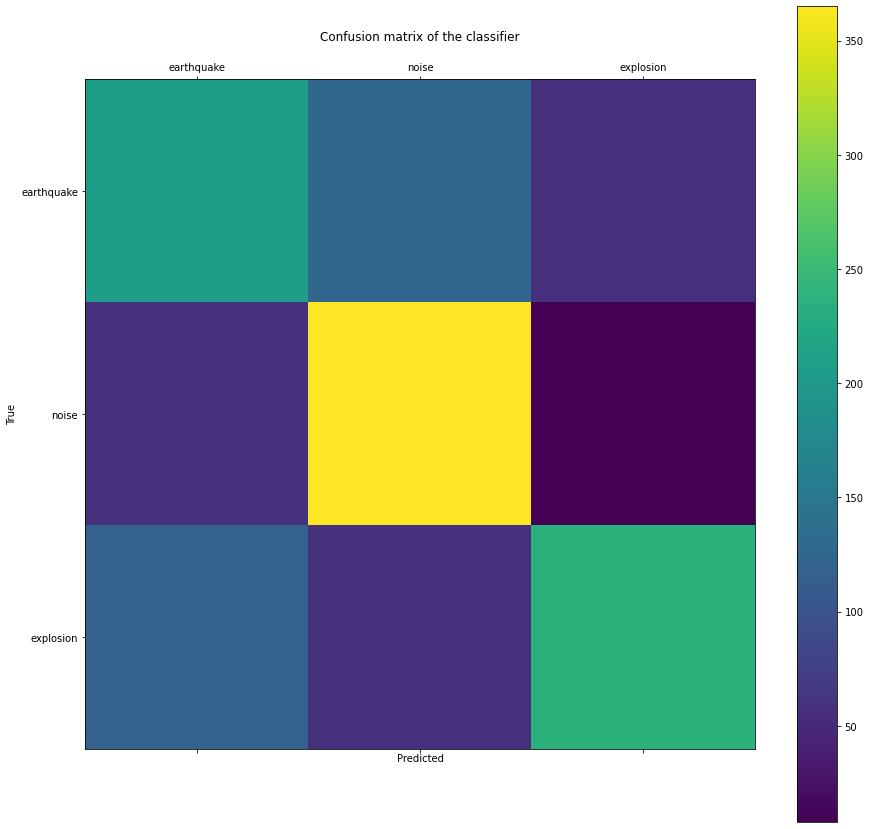

In [8]:
helper.plot_confusion_matrix(model, test_gen, test_ds, batch_size, num_classes)

In [ ]:
model.predict_generator(val_gen, 2)

In [ ]:
helper.plot_confusion_matrix(test_ds, batch_size)